In [55]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [77]:
include(joinpath(@__DIR__, "..", "data", "nested_boolean_gen.jl"))
include(joinpath(@__DIR__, "..", "data", "hrm_common_nested_boolean_FLUX.jl"))

using .BooleanDataGenerator
using .HRMFlux

include(joinpath(@__DIR__, "..", "data", "hh_nested_boolean_FLUX.jl"))
using .HRMFluxHH

using StatsBase
using Random, Statistics
using Flux, Zygote, Optimisers
using Flux: onehotbatch, onecold
using DataFrames, Plots

In [57]:
mutable struct TrainLog
    model::String
    epochs::Vector{Int}
    pB::Vector{Float64}
    loss::Vector{Float64}
    id::Vector{Float64}
    mid::Vector{Float64}
    ood::Vector{Float64}
    ood7::Vector{Float64}
    ood8::Vector{Float64}
end

newlog(model::String) = TrainLog(model, Int[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[])

function push_epoch!(log::TrainLog; epoch::Int, pB::Float64, loss::Float64,
                     acc_id::Float64, acc_mid::Float64, acc_ood::Float64,
                     acc7::Float64, acc8::Float64)
    push!(log.epochs, epoch)
    push!(log.pB, pB)
    push!(log.loss, loss)
    push!(log.id, acc_id)
    push!(log.mid, acc_mid)
    push!(log.ood, acc_ood)
    push!(log.ood7, acc7)
    push!(log.ood8, acc8)
    return log
end

function to_dataframe(log::TrainLog)
    n = length(log.epochs)
    return DataFrame(
        model = fill(log.model, n),
        epoch = log.epochs,
        pB    = log.pB,
        loss  = log.loss,
        ID    = log.id,
        MID   = log.mid,
        OOD   = log.ood,
        OOD7  = log.ood7,
        OOD8  = log.ood8,
    )
end

function summarize(log::TrainLog)
    n = length(log.epochs)
    i_last = n
    i_peak_ood = argmax(log.ood)
    return (
        model = log.model,
        last = (
            epoch = log.epochs[i_last],
            pB    = log.pB[i_last],
            loss  = log.loss[i_last],
            ID    = log.id[i_last],
            MID   = log.mid[i_last],
            OOD   = log.ood[i_last],
            OOD7  = log.ood7[i_last],
            OOD8  = log.ood8[i_last],
        ),
        peak_ood = (
            epoch = log.epochs[i_peak_ood],
            pB    = log.pB[i_peak_ood],
            ID    = log.id[i_peak_ood],
            MID   = log.mid[i_peak_ood],
            OOD   = log.ood[i_peak_ood],
        )
    )
end

summarize (generic function with 1 method)

In [58]:
# Training data (depth 2-4)
X_train, y_trainainainain, _ = BooleanDataGenerator.generate_data(100; min_depth=2, max_depth=4)

# Test data (depth 5-8) 
X_test, y_test, _ = BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=8)

# Test data (held-out NAND)
X_test_ops, y_test_ops, _ = BooleanDataGenerator.generate_data(20; held_out_ops=[:NAND])

([1 1 … 1 1; 1 0 … 0 0; … ; 0 1 … 1 0; 0 1 … 0 1], [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1], ["(NOT (AND x1 (XOR x1 x1)))", "(AND x5 x2)", "(NOT x3)", "(OR x2 x4)", "(OR x2 (AND x3 x3))", "(XOR (OR x2 x4) (XOR x3 x2))", "(XOR x2 x5)", "(OR x2 x4)", "(NOT (AND x3 (OR x4 x5)))", "(OR x2 x5)", "(OR x3 (OR x4 x5))", "(AND x4 (AND (XOR x4 x3) x3))", "(OR x1 (OR x1 x3))", "(OR x5 x2)", "(OR x4 x1)", "(AND (AND x2 (XOR x2 x4)) (AND x1 x1))", "(NOT x1)", "(OR x5 (OR x1 x4))", "(XOR x3 (NOT x5))", "(OR (NOT x5) (OR x1 x2))"])

In [59]:
# Generate training data (depth 2-4)
X_train, y_train, expr_train = BooleanDataGenerator.generate_data(100; min_depth=2, max_depth=4, seed=42)

# Generate test data with depth generalization (depth 5-8)
X_test, y_test, expr_test = BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=8, seed=123)

# Generate test data with held-out operations (no NAND)
X_test_ops, y_test_ops, expr_test_ops = BooleanDataGenerator.generate_data(20; held_out_ops=[:NAND], seed=456)

println("Training: X=$(size(X_train)), y=$(size(y_train))")
println("Test (depth): X=$(size(X_test)), y=$(size(y_test))")
println("Test (ops): X=$(size(X_test_ops)), y=$(size(y_test_ops))")

# Show a few examples
println("\nTraining examples:")
for i in 1:3
    println("$(expr_train[i]) | vars=$(X_train[i,:]) → $(y_train[i])")
end


Training: X=(100, 5), y=(100,)
Test (depth): X=(20, 5), y=(20,)
Test (ops): X=(20, 5), y=(20,)

Training examples:
(NOT (AND x1 (NAND x1 x1))) | vars=[1, 1, 1, 1, 1] → 1
(AND x5 x2) | vars=[1, 0, 0, 0, 0] → 0
(NOT x3) | vars=[1, 1, 1, 0, 1] → 0


In [60]:
# Train (depth 2-4), Test-ID (2-4), Test-OOD (5-8)
X_train, y_train, expr_train = BooleanDataGenerator.generate_data(2000; variable_count=6, min_depth=2, max_depth=4, seed=1)
X_id,    y_test_id,    expr_id    = BooleanDataGenerator.generate_data(500;  variable_count=6, min_depth=2, max_depth=4, seed=2)
X_ood,   y_ood,   expr_ood   = BooleanDataGenerator.generate_data(500;  variable_count=6, min_depth=5, max_depth=8, seed=3)


([0 1 … 0 1; 0 0 … 1 1; … ; 1 0 … 0 0; 0 1 … 0 0], [1, 0, 1, 1, 1, 1, 1, 0, 1, 1  …  1, 1, 0, 1, 1, 0, 1, 0, 0, 0], ["(OR (NAND (NOT (NAND x1 x5)) (XOR x6 (AND x2 x5))) (AND x5 x6))", "(NOT (NOT (OR x3 (OR x1 x3))))", "(XOR x5 (OR (XOR x4 (OR x6 x2)) x3))", "(NAND (OR (OR x3 x3) (NAND x1 x2)) (XOR (NAND (XOR x2 x2) x6) (OR x4 (NOT x2))))", "(NAND (NAND (NAND (OR x1 x3) (NOT x5)) x5) (NAND x4 x1))", "(NOT (XOR (NAND x6 (XOR x2 x1)) x4))", "(NOT (NOT (OR (NAND x1 x6) x5)))", "(AND x4 (OR (NAND x5 (NAND x6 x3)) (NOT (OR x4 x6))))", "(OR (XOR (XOR x4 (NAND x3 x3)) (AND x2 x3)) (NAND x2 x3))", "(NAND (XOR x5 x5) (XOR x4 (NOT (NAND x6 x4))))"  …  "(NAND x3 (AND (XOR (NAND x4 x3) x3) x5))", "(NAND (NAND x6 (XOR x6 x2)) (NOT (NOT (AND x3 x1))))", "(XOR (NAND x6 (NAND (XOR x6 x5) (NAND x4 x3))) (XOR x6 x2))", "(XOR x2 (OR (NAND x6 (NAND x4 x1)) (AND x4 x2)))", "(OR x5 (NOT (XOR (NAND x1 x2) x6)))", "(AND (NOT (XOR x2 (OR x4 x6))) (XOR x4 (XOR (AND x4 x2) (AND x6 (NAND x1 x1)))))", "(NOT (NOT (N

In [61]:
function tokenize_with_assignment(expression::String, variable_row::AbstractVector{<:Integer})
    spaced = replace(expression, r"([()])" => s" \1 ")
    raw_tokens = split(strip(spaced))
    tokens = String[]
    for t in raw_tokens
        if startswith(t, "x")
            idx = parse(Int, t[2:end])
            push!(tokens, "x$(idx)=$(variable_row[idx])")
        elseif t == "(" || t == ")"
            continue  # drop parentheses to shorten sequences
        else
            push!(tokens, t)  # "AND", "OR", "XOR", "NAND", "NOT"
        end
    end
    return tokens
end


# Build token sequences
function build_token_sequences(expressions::Vector{String}, X::Array{Int,2})
    seqs = Vector{Vector{String}}(undef, length(expressions))
    for i in eachindex(expressions)
        seqs[i] = tokenize_with_assignment(expressions[i], vec(X[i, :]))
    end
    return seqs
end

train_tokens = build_token_sequences(expr_train, X_train)
id_tokens    = build_token_sequences(expr_id,    X_id)
ood_tokens   = build_token_sequences(expr_ood,   X_ood)


500-element Vector{Vector{String}}:
 ["OR", "NAND", "NOT", "NAND", "x1=0", "x5=0", "XOR", "x6=1", "AND", "x2=1", "x5=0", "AND", "x5=0", "x6=1"]
 ["NOT", "NOT", "OR", "x3=0", "OR", "x1=0", "x3=0"]
 ["XOR", "x5=0", "OR", "XOR", "x4=0", "OR", "x6=0", "x2=1", "x3=0"]
 ["NAND", "OR", "OR", "x3=1", "x3=1", "NAND", "x1=1", "x2=0", "XOR", "NAND", "XOR", "x2=0", "x2=0", "x6=0", "OR", "x4=1", "NOT", "x2=0"]
 ["NAND", "NAND", "NAND", "OR", "x1=0", "x3=0", "NOT", "x5=1", "x5=1", "NAND", "x4=0", "x1=0"]
 ["NOT", "XOR", "NAND", "x6=1", "XOR", "x2=1", "x1=1", "x4=1"]
 ["NOT", "NOT", "OR", "NAND", "x1=1", "x6=1", "x5=1"]
 ["AND", "x4=0", "OR", "NAND", "x5=0", "NAND", "x6=1", "x3=1", "NOT", "OR", "x4=0", "x6=1"]
 ["OR", "XOR", "XOR", "x4=0", "NAND", "x3=1", "x3=1", "AND", "x2=0", "x3=1", "NAND", "x2=0", "x3=1"]
 ["NAND", "XOR", "x5=0", "x5=0", "XOR", "x4=0", "NOT", "NAND", "x6=1", "x4=0"]
 ⋮
 ["NAND", "NAND", "x6=0", "XOR", "x6=0", "x2=1", "NOT", "NOT", "AND", "x3=0", "x1=0"]
 ["XOR", "NAND", "x6=0", "

In [62]:
# Vocabulary from training tokens only
function build_vocab(token_sequences::Vector{Vector{String}})
    vocab = Dict{String,Int}()
    next_id = 1
    for seq in token_sequences
        for t in seq
            if !haskey(vocab, t)
                vocab[t] = next_id
                next_id += 1
            end
        end
    end
    return vocab
end

vocab = build_vocab(train_tokens)
unk_id = length(vocab) + 1  # just in case (should not be needed here)

# Map tokens to integer ids
token_to_id_tmp = t -> get(vocab, t, unk_id)
function map_to_ids(token_sequences::Vector{Vector{String}})
    return [map(token_to_id_tmp, seq) for seq in token_sequences]
end

train_ids = map_to_ids(train_tokens)
id_ids    = map_to_ids(id_tokens)
ood_ids   = map_to_ids(ood_tokens)


500-element Vector{Vector{Int64}}:
 [6, 9, 14, 9, 15, 3, 12, 2, 1, 10, 3, 1, 3, 2]
 [14, 14, 6, 13, 6, 15, 13]
 [12, 3, 6, 12, 11, 6, 7, 10, 13]
 [9, 6, 6, 8, 8, 9, 17, 4, 12, 9, 12, 4, 4, 7, 6, 5, 14, 4]
 [9, 9, 9, 6, 15, 13, 14, 16, 16, 9, 11, 15]
 [14, 12, 9, 2, 12, 10, 17, 5]
 [14, 14, 6, 9, 17, 2, 16]
 [1, 11, 6, 9, 3, 9, 2, 8, 14, 6, 11, 2]
 [6, 12, 12, 11, 9, 8, 8, 1, 4, 8, 9, 4, 8]
 [9, 12, 3, 3, 12, 11, 14, 9, 2, 11]
 ⋮
 [9, 9, 7, 12, 7, 10, 14, 14, 1, 13, 15]
 [12, 9, 7, 9, 12, 7, 3, 9, 11, 8, 12, 7, 10]
 [12, 10, 6, 9, 2, 9, 11, 15, 1, 11, 10]
 [6, 3, 14, 12, 9, 17, 4, 2]
 [1, 14, 12, 4, 6, 5, 7, 12, 5, 12, 1, 5, 4, 1, 7, 9, 15, 15]
 [14, 14, 9, 12, 2, 5, 12, 16, 10]
 [1, 7, 9, 1, 14, 3, 1, 15, 7, 14, 9, 11, 7]
 [14, 12, 12, 13, 7, 6, 6, 3, 5, 14, 5]
 [14, 9, 1, 1, 11, 3, 1, 3, 3, 12, 7, 13]

In [ ]:
VARIABLE_COUNT = 6
N_A   = 5000   # Train Phase A (2-4)
N_B   = 10000   # Train Phase B (2-6)
N_ID  = 1000   # Test (2-4)
N_MID = 1000   # Test (5-6)
N_OOD = 1000   # Test (7-8)

Random.seed!(1)


function max_paren_depth(expr::String)
    d = 0; m = 0
    @inbounds for c in expr
        if c == '('
            d += 1; m = max(m, d)
        elseif c == ')'
            d -= 1
        end
    end
    return m
end




function make_depth_stratified_split(depth_counts::Dict{Int,Int};
    variable_count::Int, seed::Int)

    Xs = Matrix{Int}[]; ys = Vector{Int}[]; Es = Vector{String}[]
    for d in sort(collect(keys(depth_counts)))
        n = depth_counts[d]; n == 0 && continue
        X, y, E = BooleanDataGenerator.generate_data(n;
                            variable_count=variable_count, min_depth=d, max_depth=d, seed=seed + d,
                            mode = :exact)
        push!(Xs, X); push!(ys, y); push!(Es, E)
    end
    X_all = vcat(Xs...)                 # (N_total, variable_count)
    y_all = reduce(vcat, ys)            # (N_total,)
    E_all = reduce(vcat, Es)            # Vector{String} length N_total

    # Shuffle ROWS (samples) — NOT columns
    perm = randperm(size(X_all, 1))
    return X_all[perm, :], y_all[perm], E_all[perm]
end



# Train pools
# Train Phase A: (2,3,4)
X_tr_A, y_tr_A, expr_tr_A =
    make_depth_stratified_split(Dict(2=>N_A÷3, 3=>N_A÷3, 4=>N_A - 2*(N_A÷3));
                                variable_count=VARIABLE_COUNT, seed=101)

# Train Phase B: (2,3,4,5,6) equal-ish
X_tr_B, y_tr_B, expr_tr_B =
    make_depth_stratified_split(Dict(2=>N_B÷5, 3=>N_B÷5, 4=>N_B÷5, 5=>N_B÷5, 6=>N_B - 4*(N_B÷5));
                                variable_count=VARIABLE_COUNT, seed=102)

# Test ID: (2,3,4)
X_te_ID,  y_te_ID,  expr_te_ID  =
    make_depth_stratified_split(Dict(2=>N_ID÷3, 3=>N_ID÷3, 4=>N_ID - 2*(N_ID÷3));
                                variable_count=VARIABLE_COUNT, seed=201)

# Test MID: (5,6)
X_te_MID, y_te_MID, expr_te_MID =
    make_depth_stratified_split(Dict(5=>N_MID÷2, 6=>N_MID - (N_MID÷2));
                                variable_count=VARIABLE_COUNT, seed=202)

# Test OOD: (7,8)
X_te_OOD, y_te_OOD, expr_te_OOD =
    make_depth_stratified_split(Dict(7=>N_OOD÷2, 8=>N_OOD - (N_OOD÷2));
                                variable_count=VARIABLE_COUNT, seed=203)

let d = [max_paren_depth(e)+1 for e in expr_te_OOD]
    @assert all(x -> x==7 || x==8, d) "Found non-(7,8) depths in OOD split: $(StatsBase.countmap(d))"
end




# 2) Tokenize with assignment, build vocab, pad to fixed length
function tokenize_with_assignment(expression::String, variable_row::AbstractVector{<:Integer})
    spaced = replace(expression, r"([()])" => s" \1 ")
    raw_tokens = split(strip(spaced))
    tokens = String[]
    for t in raw_tokens
        if startswith(t, "x")
            idx = parse(Int, t[2:end])
            push!(tokens, "x$(idx)=$(variable_row[idx])")
        elseif t == "(" || t == ")"
            continue  # drop parentheses to shorten sequences (consistent with earlier runs)
        else
            push!(tokens, t)  # "AND", "OR", "XOR", "NAND", "NOT"
        end
    end
    return tokens
end


function build_token_sequences(expressions::Vector{String}, X::Array{Int,2})
    seqs = Vector{Vector{String}}(undef, length(expressions))
    for i in eachindex(expressions)
        seqs[i] = tokenize_with_assignment(expressions[i], vec(X[i, :]))
    end
    return seqs
end


# Tokenize every split
tokens_tr_A  = build_token_sequences(expr_tr_A,  X_tr_A)
tokens_tr_B  = build_token_sequences(expr_tr_B,  X_tr_B)
tokens_te_ID = build_token_sequences(expr_te_ID, X_te_ID)
tokens_te_M  = build_token_sequences(expr_te_MID,X_te_MID)
tokens_te_O  = build_token_sequences(expr_te_OOD,X_te_OOD)

function build_vocab_with_specials(train_token_sequences::Vector{Vector{String}})
    vocab = Dict{String,Int}("<PAD>"=>1, "<UNK>"=>2)
    next_id = 3
    for seq in train_token_sequences
        for t in seq
            haskey(vocab, t) || (vocab[t] = next_id; next_id += 1)
        end
    end
    return vocab
end

vocab = build_vocab_with_specials(tokens_tr_A)
const PAD_ID = vocab["<PAD>"]
const UNK_ID = vocab["<UNK>"]
token_to_id(t) = get(vocab, t, UNK_ID)

# --- Map tokens -> ids (produces (L, N) matrices) ---
function to_ids(tokens::Vector{Vector{String}})
    Lmax = maximum(length.(tokens))
    n = length(tokens)
    Xids = fill(PAD_ID, Lmax, n)
    @inbounds for i in 1:n
        s = tokens[i]
        for j in 1:length(s)
            Xids[j, i] = token_to_id(s[j])
        end
    end
    return Xids
end

Xids_tr_A  = to_ids(tokens_tr_A)
Xids_tr_B  = to_ids(tokens_tr_B)
Xids_te_ID = to_ids(tokens_te_ID)
Xids_te_M  = to_ids(tokens_te_M)
Xids_te_O  = to_ids(tokens_te_O)


# Compute the maximum sequence length across *all* splits
L_A   = size(Xids_tr_A,  1)
L_B   = size(Xids_tr_B,  1)
L_ID  = size(Xids_te_ID, 1)
L_MID = size(Xids_te_M,  1)
L_OOD = size(Xids_te_O,  1)

# Vocabulary from training only, with <PAD>=1 and <UNK>=2
function build_vocab_with_specials(train_token_sequences::Vector{Vector{String}})
    vocab = Dict{String,Int}("<PAD>"=>1, "<UNK>"=>2)
    next_id = 3
    for seq in train_token_sequences
        for t in seq
            haskey(vocab, t) || (vocab[t] = next_id; next_id += 1)
        end
    end
    return vocab
end


# Vocab ONLY from Phase-A training (guards against leakage)
vocab = build_vocab_with_specials(tokens_tr_A)
const PAD_ID = vocab["<PAD>"]
const UNK_ID = vocab["<UNK>"]
token_to_id(t) = get(vocab, t, UNK_ID)


cfg = (
    d_in   = 0,
    d_hid  = 128,
    d_out  = 1,
    N      = 5,
    T      = 0,
    batch  = 32,
    lr     = 1e-4,
    num_tokens = length(vocab),
    d_embed    = 128,
    l_heads    = 4,
    l_ff_mult  = 6,
    h_heads    = 4,
    h_ff_mult  = 6,
    dropout    = 0.15,
    pad_id     = PAD_ID
)




# Per-split padding (no global max)
function to_ids(tokens::Vector{Vector{String}})
    Lmax = maximum(length.(tokens))
    n = length(tokens)
    Xids = fill(PAD_ID, Lmax, n)
    @inbounds for i in 1:n
        s = tokens[i]
        for j in 1:length(s)
            Xids[j, i] = token_to_id(s[j])
        end
    end
    return Xids
end


depths(v) = [max_paren_depth(e)+1 for e in v]

@show StatsBase.countmap(depths(expr_tr_A))
@show StatsBase.countmap(depths(expr_tr_B))
@show StatsBase.countmap(depths(expr_te_ID))
@show StatsBase.countmap(depths(expr_te_MID))
@show StatsBase.countmap(depths(expr_te_OOD))


# +1 if you use CLS (the CLS token is prepended to H_in)
POS_L_MAX = max(L_A, L_B, L_ID, L_MID, L_OOD) + 1

models = HRMFlux.build_models(cfg;
    l_positional_encoding_kind=:none,
    h_positional_encoding_kind=:sinusoidal,
    pos_L_max=POS_L_MAX)



function seq_lengths_from_pad_id(Xids::AbstractMatrix{<:Integer}, pad_id::Int)
    L, B = size(Xids)
    lengths = fill(L, B)
    @inbounds for b in 1:B
        for t in 1:L
            if Xids[t, b] == pad_id
                lengths[b] = t - 1
                break
            end
        end
    end
    return lengths
end



# keep PAD embedding at zero to avoid length bias
if models.tok_emb !== nothing
    models.tok_emb.weight[:, PAD_ID] .= 0f0
end


function each_minibatch_bucketed(X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer};
                                 batch::Int, buckets::Int=6, pad_id::Int=PAD_ID)
    L, N = size(X)
    lens = fill(L, N)
    @inbounds for i in 1:N, t in 1:L
        if X[t,i] == pad_id
            lens[i] = t-1
            break
        end
    end
    order  = sortperm(1:N, by=i->lens[i])
    groups = Iterators.partition(order, max(1, ceil(Int, N/buckets)))
    out = Vector{Tuple{Matrix{Int}, Vector{Int}}}()
    for g in groups
        idx = collect(g); Random.shuffle!(idx)
        for k in 1:batch:length(idx)
            sel = idx[k:min(k+batch-1, length(idx))]
            push!(out, (X[:, sel], y[sel]))
        end
    end
    return out
end


function each_minibatch(X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, batch_size::Int)
    idx = collect(1:size(X, 2))
    Random.shuffle!(idx)
    out = Vector{Tuple{Matrix{Int}, Vector{Int}}}()
    for k in 1:batch_size:length(idx)
        sel = idx[k:min(k+batch_size-1, length(idx))]
        push!(out, (X[:, sel], y[sel]))
    end
    return out
end


"Yield a mixed stream of mini-batches from A and B with probability pB for B."
function each_minibatch_mixed(XA::AbstractMatrix{<:Integer}, yA::AbstractVector{<:Integer},
                              XB::AbstractMatrix{<:Integer}, yB::AbstractVector{<:Integer};
                              batch::Int, pB::Float64, buckets::Int=6, pad_id::Int=PAD_ID)

    itA = each_minibatch_bucketed(XA, yA; batch=batch, buckets=buckets, pad_id=pad_id)
    itB = each_minibatch_bucketed(XB, yB; batch=batch, buckets=buckets, pad_id=pad_id)

    ia = 1; ib = 1
    out = Vector{Tuple{Matrix{Int}, Vector{Int}}}()
    while ia <= length(itA) || ib <= length(itB)
        useB = rand() < pB
        if useB && ib <= length(itB)
            push!(out, itB[ib]); ib += 1
        elseif ia <= length(itA)
            push!(out, itA[ia]); ia += 1
        elseif ib <= length(itB)
            push!(out, itB[ib]); ib += 1
        end
    end
    return out
end



function batch_loss(models, x_batch::AbstractMatrix{<:Integer}, y_batch::AbstractVector{<:Integer}, cfg)
    batch_size = size(x_batch, 2)
    low_state, high_state = HRMFlux.init_states(batch_size, cfg.d_hid)
    
    # yhat, _, _ = HRMFlux.run_segment_GRU!(models, x_batch, low_state, high_state; N=cfg.N, T=cfg.T, cfg=cfg)
    yhat, _, _ = HRMFlux.run_sequence_segment!(models, x_batch, low_state, high_state; N=cfg.N, cfg=cfg)

    targets = reshape(Float32.(y_batch), 1, batch_size)
    return Flux.logitbinarycrossentropy(yhat, targets)
end


# function accuracy(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
#     correct = 0
#     total = 0
#     for (xb, yb) in each_minibatch(X, y, batch_size)
#         bs = size(xb, 2)
#         low_state, high_state = HRMFlux.init_states(bs, cfg.d_hid)
#         yhat, _, _ = HRMFlux.run_sequence_segment!(models, xb, low_state, high_state; N=cfg.N, cfg=cfg)
#         preds = @. yhat > 0
#         correct += sum(Int.(preds[1, :]) .== yb)
#         total   += bs
#     end
#     return correct / total
# end


function accuracy(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
    correct = 0
    total = 0
    # use the function arguments X, y — not Xtr, ytr
    for (xb, yb) in each_minibatch_bucketed(X, y; batch=min(cfg.batch, batch_size), buckets=6)
        bs = size(xb, 2)
        low_state, high_state = HRMFlux.init_states(bs, cfg.d_hid)

        yhat, _, _ = HRMFlux.run_sequence_segment!(models, xb, low_state, high_state; N=cfg.N, cfg=cfg)
        preds = @. yhat > 0
        correct += sum(Int.(preds[1, :]) .== yb)
        total   += bs
    end
    return correct / total
end




function accuracy_by_depth(models, Xids, y, exprs; cfg, batch_size=256)
    de = [max_paren_depth(e) + 1 for e in exprs]  # structural depth
    mp = Dict{Int, Vector{Int}}()
    for (i,d) in enumerate(de)
        push!(get!(mp, d, Int[]), i)
    end
    out = Dict{Int,Float64}()
    for (d, idx) in sort(collect(mp); by=first)
        out[d] = accuracy(models, Xids[:, idx], y[idx], cfg; batch_size=batch_size)
    end
    return out
end



@assert size(X_tr_A,2) == VARIABLE_COUNT
@assert length(y_tr_A) == size(X_tr_A,1) == length(expr_tr_A)
@assert length(y_tr_B) == size(X_tr_B,1) == length(expr_tr_B)
@assert length(y_te_ID)  == size(X_te_ID,1)  == length(expr_te_ID)
@assert length(y_te_MID) == size(X_te_MID,1) == length(expr_te_MID)
@assert length(y_te_OOD) == size(X_te_OOD,1) == length(expr_te_OOD)

@assert size(Xids_tr_A,2) == size(X_tr_A,1)
@assert size(Xids_te_O, 2) == size(X_te_OOD,1)



# 5) Train and evaluate
# curriculum phases
epochs_A = 2    # Phase A (2-4)
epochs_B = 2    # Phase B (2-6)
total_epochs = epochs_A + epochs_B

base_lr = cfg.lr
opt = Optimisers.Adam(base_lr)
opt_state = Optimisers.setup(opt, models)

#    cosine ramp helpers & bounds for Phase-B mixing  
const MIN_MIX_IN_B = 0.30     # lower bound once Phase B starts
const MAX_MIX_IN_B = 1.00     # cap at full B
cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))   # maps [0,1] -> [0,1] smoothly

@info "Curriculum: epochs_A=$(epochs_A) epochs_B=$(epochs_B)  MIN_MIX_IN_B=$(MIN_MIX_IN_B)"

log_HL = newlog("H+L")


for epoch in 1:total_epochs
    total_loss = 0.0; batches = 0

    #  0.0 during Phase A; smooth cosine ramp during Phase B  
    if epoch <= epochs_A
        pB = 0.0
    else
        tB = (epoch - epochs_A) / epochs_B            # progress in Phase B, 0..1
        pB = MIN_MIX_IN_B + (MAX_MIX_IN_B - MIN_MIX_IN_B) * cosine01(tB)
    end

    # (optional) quick sanity print every few epochs
    if epoch == 1 || epoch == epochs_A || epoch == epochs_A+1 || epoch == total_epochs
        @info "epoch=$(epoch): pB=$(round(pB, digits=3))"
    end

    for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                         batch=cfg.batch, pB=pB, buckets=6, pad_id=PAD_ID)

        # keep PAD column neutral (before & after update)
        if hasproperty(models, :tok_emb) && models.tok_emb !== nothing
            models.tok_emb.weight[:, PAD_ID] .= 0f0
        end

        L, back = Zygote.pullback(m -> batch_loss(m, xb, yb, cfg), models)
        grads = back(one(L))[1]
        opt_state, models = Optimisers.update(opt_state, models, grads)

        if hasproperty(models, :tok_emb) && models.tok_emb !== nothing
            models.tok_emb.weight[:, PAD_ID] .= 0f0
        end

        total_loss += Float64(L); batches += 1
    end

    acc_id  = accuracy(models, Xids_te_ID,  y_te_ID,  cfg)   # 2-4
    acc_mid = accuracy(models, Xids_te_M,   y_te_MID, cfg)   # 5-6
    acc_ood = accuracy(models, Xids_te_O,   y_te_OOD, cfg)   # 7-8
    @info "epoch=$(epoch)  loss=$(round(total_loss/batches, digits=4))  " *
          "ID(2-4)=$(round(acc_id,digits=3))  MID(5-6)=$(round(acc_mid,digits=3))  OOD(7-8)=$(round(acc_ood,digits=3))"

    ood = accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    acc7 = get(ood, 7, NaN); 
    acc8 = get(ood, 8, NaN)
    ood_macro = (acc7 + acc8) / 2
    @info "OOD macro (7/8 equally) = $(round(ood_macro, digits=3))"

    mean_loss = total_loss / max(batches, 1)
    push_epoch!(log_HL; epoch=epoch, pB=pB, loss=mean_loss,
                acc_id=acc_id, acc_mid=acc_mid, acc_ood=acc_ood,
                acc7=acc7, acc8=acc8)

    if epoch % 5 == 0
        @show accuracy_by_depth(models, Xids_te_O,  y_te_OOD,  expr_te_OOD;  cfg=cfg)
        @show accuracy_by_depth(models, Xids_te_M,  y_te_MID,  expr_te_MID;  cfg=cfg)
        println("Final depth bins (OOD 7-8):")
        @show accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    end
end

println("Final depth bins (OOD 7-8):")
@show accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)

println("Final depth bins (MID 5-6):")
@show accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg=cfg)

println("Done.")

StatsBase.countmap(depths(expr_tr_A)) = Dict(4 => 1668, 2 => 1666, 3 => 1666)
StatsBase.countmap(depths(expr_tr_B)) = Dict(5 => 2000, 4 => 2000, 6 => 2000, 2 => 2000, 3 => 2000)
StatsBase.countmap(depths(expr_te_ID)) = Dict(4 => 334, 2 => 333, 3 => 333)
StatsBase.countmap(depths(expr_te_MID)) = Dict(5 => 500, 6 => 500)
StatsBase.countmap(depths(expr_te_OOD)) = Dict(7 => 500, 8 => 500)


┌ Info: Curriculum: epochs_A=2 epochs_B=2  MIN_MIX_IN_B=0.3
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:406
┌ Info: epoch=1: pB=0.0
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:424
┌ Info: epoch=1  loss=0.6515  ID(2-4)=0.716  MID(5-6)=0.664  OOD(7-8)=0.656
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:449
┌ Info: OOD macro (7/8 equally) = 0.656
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:456
┌ Info: epoch=2: pB=0.0
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730

Final depth bins (OOD 7-8):


┌ Info: OOD macro (7/8 equally) = 0.675
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:456


accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.678, 8 => 0.672)
Final depth bins (MID 5-6):
accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.688, 6 => 0.664)
Done.


In [68]:
# H+H ZONE

In [ ]:
# models_hh = HRMFluxHH.build_models(cfg;
#     l_positional_encoding_kind = :sinusoidal,  # H1
#     h_positional_encoding_kind = :sinusoidal,  # H2
#     pos_L_max = POS_L_MAX)

# models_hh.tok_emb !== nothing && (models_hh.tok_emb.weight[:, PAD_ID] .= 0f0)

# bs = size(xb, 2)
# h1, h2 = HRMFluxHH.init_states(bs, cfg.d_hid)
# yhat, _, _ = HRMFluxHH.run_sequence_segment!(models_hh, xb, h1, h2; N=cfg.N, cfg=cfg)
# # compute loss, backprop, update ... same as HRM (H+L)

In [ ]:


# 2) Build the H+H model (sinusoidal PEs for both high modules; fair baseline)
models_hh = HRMFluxHH.build_models(cfg;
    l_positional_encoding_kind = :sinusoidal,   # H1
    h_positional_encoding_kind = :sinusoidal,   # H2
    pos_L_max = POS_L_MAX)                      # >= max sequence length + CLS

# Keep PAD embedding at zero to avoid length bias
if models_hh.tok_emb !== nothing
    models_hh.tok_emb.weight[:, PAD_ID] .= 0f0
end

# 3) Loss and metrics specialized for H+H
function batch_loss_hh(models, x_batch::AbstractMatrix{<:Integer}, y_batch::AbstractVector{<:Integer}, cfg)
    B = size(x_batch, 2)
    h1, h2 = HRMFluxHH.init_states(B, cfg.d_hid)
    yhat, _, _ = HRMFluxHH.run_sequence_segment!(models, x_batch, h1, h2; N=cfg.N, cfg=cfg)
    targets = reshape(Float32.(y_batch), 1, B)
    return Flux.logitbinarycrossentropy(yhat, targets)
end

function accuracy_hh(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
    correct = 0; total = 0
    for (xb, yb) in each_minibatch_bucketed(X, y; batch=min(cfg.batch, batch_size), buckets=6, pad_id=PAD_ID)
        B = size(xb, 2)
        h1, h2 = HRMFluxHH.init_states(B, cfg.d_hid)
        yhat, _, _ = HRMFluxHH.run_sequence_segment!(models, xb, h1, h2; N=cfg.N, cfg=cfg)
        preds = @. yhat > 0
        correct += sum(Int.(preds[1, :]) .== yb)
        total   += B
    end
    return correct / total
end

function accuracy_by_depth_hh(models, Xids, y, exprs; cfg, batch_size=256)
    de = [max_paren_depth(e) + 1 for e in exprs]  # structural depth
    mp = Dict{Int, Vector{Int}}()
    for (i,d) in enumerate(de)
        push!(get!(mp, d, Int[]), i)
    end
    out = Dict{Int,Float64}()
    for (d, idx) in sort(collect(mp); by=first)
        out[d] = accuracy_hh(models, Xids[:, idx], y[idx], cfg; batch_size=batch_size)
    end
    return out
end



base_lr_hh = cfg.lr
opt_hh = Optimisers.Adam(base_lr_hh)
opt_state_hh = Optimisers.setup(opt_hh, models_hh)

MIN_MIX_IN_B_HH = 0.30     # lower bound once Phase B starts
MAX_MIX_IN_B_HH = 1.00     # cap at full B
cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))   # maps [0,1] -> [0,1] smoothly

@info "H+H Curriculum: epochs_A=$(epochs_A) epochs_B=$(epochs_B)  MIN_MIX_IN_B=$(MIN_MIX_IN_B_HH)"

log_HH = newlog("H+H")

for epoch in 1:total_epochs
    total_loss = 0.0; batches = 0

    # 0.0 during Phase A; smooth cosine ramp during Phase B
    pB = if epoch <= epochs_A
        0.0
    else
        tB = (epoch - epochs_A) / epochs_B
        MIN_MIX_IN_B_HH + (MAX_MIX_IN_B_HH - MIN_MIX_IN_B_HH) * cosine01(tB)
    end

    # sanity print (same checkpoints as your H+L loop)
    if epoch == 1 || epoch == epochs_A || epoch == epochs_A+1 || epoch == total_epochs
        @info "H+H epoch=$(epoch): pB=$(round(pB, digits=3))"
    end

    for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                         batch=cfg.batch, pB=pB, buckets=6, pad_id=PAD_ID)

        # keep PAD column neutral (before & after update)
        if hasproperty(models_hh, :tok_emb) && models_hh.tok_emb !== nothing
            models_hh.tok_emb.weight[:, PAD_ID] .= 0f0
        end

        L, back = Zygote.pullback(m -> batch_loss_hh(m, xb, yb, cfg), models_hh)
        grads = back(one(L))[1]
        opt_state_hh, models_hh = Optimisers.update(opt_state_hh, models_hh, grads)

        if hasproperty(models_hh, :tok_emb) && models_hh.tok_emb !== nothing
            models_hh.tok_emb.weight[:, PAD_ID] .= 0f0
        end

        total_loss += Float64(L); batches += 1
    end

    acc_id  = accuracy_hh(models_hh, Xids_te_ID,  y_te_ID,  cfg)   # 2-4
    acc_mid = accuracy_hh(models_hh, Xids_te_M,   y_te_MID, cfg)   # 5-6
    acc_ood = accuracy_hh(models_hh, Xids_te_O,   y_te_OOD, cfg)   # 7-8
    @info "H+H epoch=$(epoch)  loss=$(round(total_loss/batches, digits=4))  " *
          "ID(2-4)=$(round(acc_id,digits=3))  MID(5-6)=$(round(acc_mid,digits=3))  OOD(7-8)=$(round(acc_ood,digits=3))"

    ood = accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    acc7 = get(ood, 7, NaN); 
    acc8 = get(ood, 8, NaN)
    ood_macro = (acc7 + acc8) / 2

    mean_loss = total_loss / max(batches, 1)
    push_epoch!(log_HH; epoch=epoch, pB=pB, loss=mean_loss,
                acc_id=acc_id, acc_mid=acc_mid, acc_ood=acc_ood,
                acc7=acc7, acc8=acc8)
        
    @info "H+H OOD macro (7/8 equally) = $(round(ood_macro, digits=3))"

    if epoch % 5 == 0
        @show accuracy_by_depth_hh(models_hh, Xids_te_O,  y_te_OOD,  expr_te_OOD;  cfg=cfg)
        @show accuracy_by_depth_hh(models_hh, Xids_te_M,  y_te_MID,  expr_te_MID;  cfg=cfg)
        println("H+H Final depth bins (OOD 7-8):")
        @show accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    end
end

println("H+H Final depth bins (OOD 7-8):")
@show accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)

println("H+H Final depth bins (MID 5-6):")
@show accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg=cfg)

println("H+H Done.")

┌ Info: H+H Curriculum: epochs_A=2 epochs_B=2  MIN_MIX_IN_B=0.3
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:60
┌ Info: H+H epoch=1: pB=0.0
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:77
┌ Info: H+H epoch=1  loss=0.6749  ID(2-4)=0.577  MID(5-6)=0.602  OOD(7-8)=0.576
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:102
┌ Info: H+H OOD macro (7/8 equally) = 0.576
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:115
┌ Info: H+H epoch=2: pB=0.0
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa

H+H Final depth bins (OOD 7-8):


┌ Info: H+H OOD macro (7/8 equally) = 0.617
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:115


accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.628, 8 => 0.606)
H+H Final depth bins (MID 5-6):
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.604, 6 => 0.626)
H+H Done.


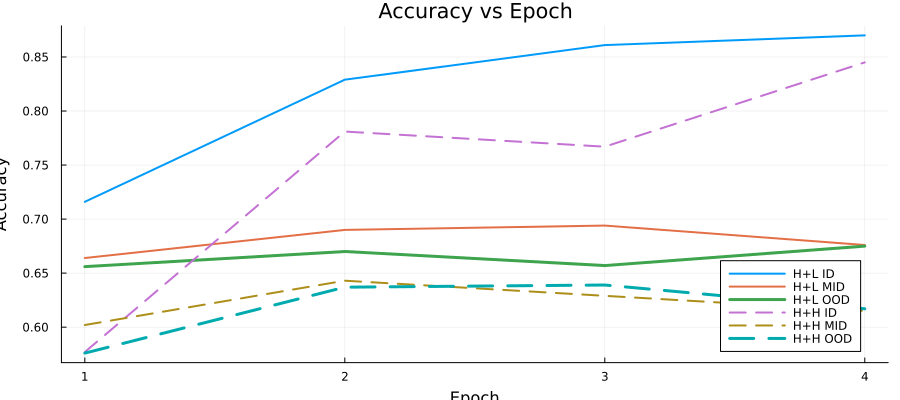

=== Final-epoch summary ===
2×9 DataFrame
 Row │ Model   Epoch  pB       Loss      ID       MID      OOD      OOD7     OOD8    
     │ String  Int64  Float64  Float64   Float64  Float64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │ H+L         4      1.0  0.374638    0.87     0.676    0.675    0.678    0.672
   2 │ H+H         4      1.0  0.417405    0.845    0.615    0.617    0.628    0.606

=== Peak-OOD summary ===
2×6 DataFrame
 Row │ Model   PeakOOD  AtEpoch  pB       ID_at    MID_at  
     │ String  Float64  Int64    Float64  Float64  Float64 
─────┼─────────────────────────────────────────────────────
   1 │ H+L       0.675        4     1.0     0.87     0.676
   2 │ H+H       0.639        3     0.65    0.767    0.629

=== Final-epoch differences (H+L − H+H) ===
6×2 DataFrame
 Row │ Metric  Delta      
     │ String  Float64    
─────┼────────────────────
   1 │ Loss    -0.0427662
   2 │ ID       0.025
   3

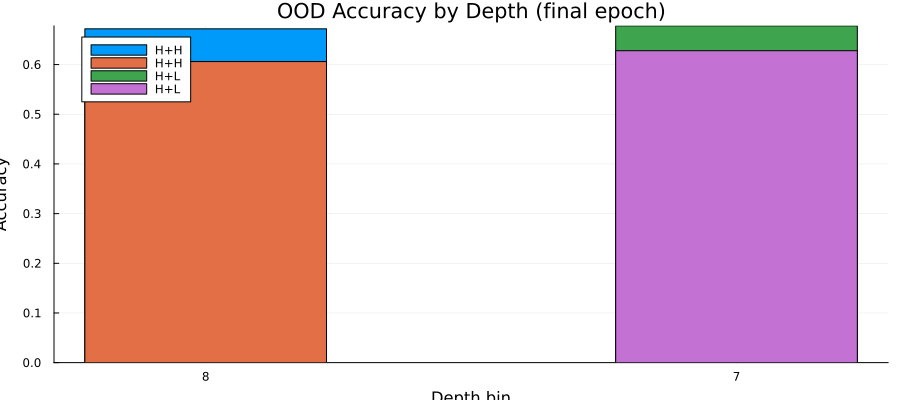

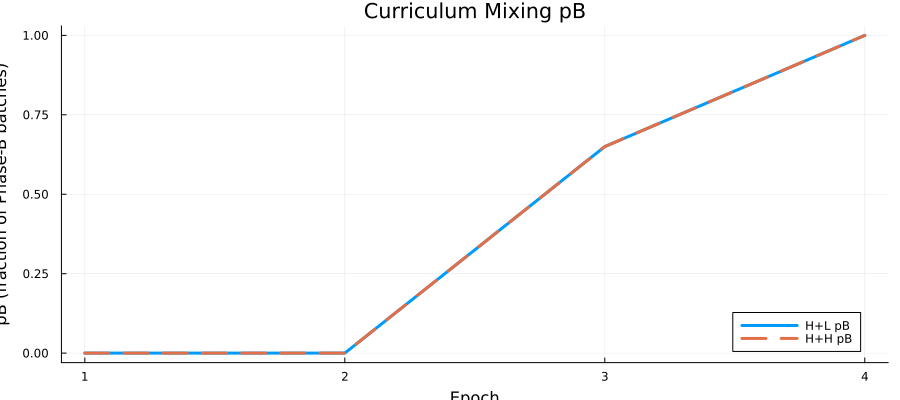

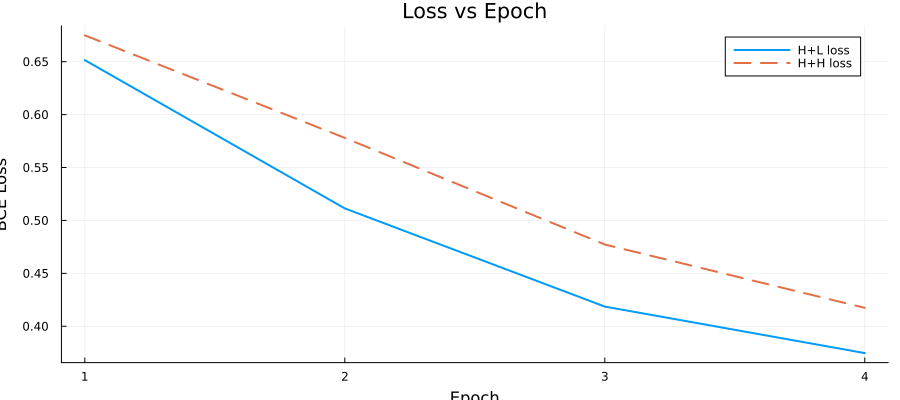

In [ ]:
# Build tidy frames from the two logs
df_HL = to_dataframe(log_HL)
df_HH = to_dataframe(log_HH)
df_all = vcat(df_HL, df_HH)

sum_HL = summarize(log_HL)
sum_HH = summarize(log_HH)

summary_last = DataFrame(
    Model = [sum_HL.model, sum_HH.model],
    Epoch = [sum_HL.last.epoch, sum_HH.last.epoch],
    pB    = [sum_HL.last.pB,    sum_HH.last.pB],
    Loss  = [sum_HL.last.loss,  sum_HH.last.loss],
    ID    = [sum_HL.last.ID,    sum_HH.last.ID],
    MID   = [sum_HL.last.MID,   sum_HH.last.MID],
    OOD   = [sum_HL.last.OOD,   sum_HH.last.OOD],
    OOD7  = [sum_HL.last.OOD7,  sum_HH.last.OOD7],
    OOD8  = [sum_HL.last.OOD8,  sum_HH.last.OOD8],
)

summary_peak = DataFrame(
    Model    = [sum_HL.model, sum_HH.model],
    PeakOOD  = [sum_HL.peak_ood.OOD, sum_HH.peak_ood.OOD],
    AtEpoch  = [sum_HL.peak_ood.epoch, sum_HH.peak_ood.epoch],
    pB       = [sum_HL.peak_ood.pB, sum_HH.peak_ood.pB],
    ID_at    = [sum_HL.peak_ood.ID, sum_HH.peak_ood.ID],
    MID_at   = [sum_HL.peak_ood.MID, sum_HH.peak_ood.MID],
)

println("=== Final-epoch summary ===")
show(summary_last; allrows=true, allcols=true)
println("\n\n=== Peak-OOD summary ===")
show(summary_peak; allrows=true, allcols=true)

# Also compute differences (H+L − H+H) for quick reporting
diff_last = DataFrame(
    Metric = ["Loss","ID","MID","OOD","OOD7","OOD8"],
    Delta  = [summary_last.Loss[1]-summary_last.Loss[2],
              summary_last.ID[1]-summary_last.ID[2],
              summary_last.MID[1]-summary_last.MID[2],
              summary_last.OOD[1]-summary_last.OOD[2],
              summary_last.OOD7[1]-summary_last.OOD7[2],
              summary_last.OOD8[1]-summary_last.OOD8[2]]
)
println("\n\n=== Final-epoch differences (H+L − H+H) ===")
show(diff_last; allrows=true, allcols=true)

# ---------- Plots ----------
Plots.default(size=(900,400))   # <- explicit to avoid UndefVarError

# (A) Accuracies over epochs (ID / MID / OOD)
p1 = plot(title="Accuracy vs Epoch", xlabel="Epoch", ylabel="Accuracy", legend=:bottomright)
plot!(p1, df_HL.epoch, df_HL.ID,  lw=2, label="H+L ID")
plot!(p1, df_HL.epoch, df_HL.MID, lw=2, label="H+L MID")
plot!(p1, df_HL.epoch, df_HL.OOD, lw=3, label="H+L OOD")
plot!(p1, df_HH.epoch, df_HH.ID,  lw=2, ls=:dash, label="H+H ID")
plot!(p1, df_HH.epoch, df_HH.MID, lw=2, ls=:dash, label="H+H MID")
plot!(p1, df_HH.epoch, df_HH.OOD, lw=3, ls=:dash, label="H+H OOD")
display(p1)

# (B) OOD per-depth (7, 8) at final epoch
final_HL = df_HL[end, :]
final_HH = df_HH[end, :]
df_ood_bins = DataFrame(
    Model = ["H+L","H+H"],
    OOD7  = [final_HL.OOD7, final_HH.OOD7],
    OOTmp = [final_HL.OOD8, final_HH.OOD8],   # temp col to build matrix conveniently
)
rename!(df_ood_bins, :OOTmp => :OOD8)

println("\n=== OOD per-depth at final epoch ===")
show(df_ood_bins; allrows=true, allcols=true)

# Build a 2×2 matrix for the grouped bar: rows = models, cols = depth bins
mat = [final_HL.OOD7  final_HL.OOD8;
       final_HH.OOD7  final_HH.OOD8]

p2 = bar(["7","8"], mat',                    # transpose so bars group by depth
         group = ["H+L","H+H"],
         xlabel="Depth bin", ylabel="Accuracy",
         title="OOD Accuracy by Depth (final epoch)",
         legend=:topleft, bar_width=0.6)
display(p2)

# (C) Curriculum pB overlay plot (to visualize the ramp)
p3 = plot(title="Curriculum Mixing pB",
          xlabel="Epoch", ylabel="pB (fraction of Phase-B batches)", legend=:bottomright)
plot!(p3, df_HL.epoch, df_HL.pB, lw=3, label="H+L pB")
plot!(p3, df_HH.epoch, df_HH.pB, lw=3, ls=:dash, label="H+H pB")
display(p3)

# (D) Loss vs epoch
p4 = plot(title="Loss vs Epoch", xlabel="Epoch", ylabel="BCE Loss", legend=:topright)
plot!(p4, df_HL.epoch, df_HL.loss, lw=2, label="H+L loss")
plot!(p4, df_HH.epoch, df_HH.loss, lw=2, ls=:dash, label="H+H loss")
display(p4)

# (E) Optional: one compact table with both last and peak OOD for quick copy/paste
df_compact = vcat(
    DataFrame(Model=sum_HL.model, Kind="Last", Epoch=sum_HL.last.epoch, pB=sum_HL.last.pB,
              ID=sum_HL.last.ID, MID=sum_HL.last.MID, OOD=sum_HL.last.OOD, OOD7=sum_HL.last.OOD7, OOD8=sum_HL.last.OOD8),
    DataFrame(Model=sum_HH.model, Kind="Last", Epoch=sum_HH.last.epoch, pB=sum_HH.last.pB,
              ID=sum_HH.last.ID, MID=sum_HH.last.MID, OOD=sum_HH.last.OOD, OOD7=sum_HH.last.OOD7, OOD8=sum_HH.last.OOD8),
    DataFrame(Model=sum_HL.model, Kind="PeakOOD", Epoch=sum_HL.peak_ood.epoch, pB=sum_HL.peak_ood.pB,
              ID=sum_HL.peak_ood.ID, MID=sum_HL.peak_ood.MID, OOD=sum_HL.peak_ood.OOD, OOD7=missing, OOD8=missing),
    DataFrame(Model=sum_HH.model, Kind="PeakOOD", Epoch=sum_HH.peak_ood.epoch, pB=sum_HH.peak_ood.pB,
              ID=sum_HH.peak_ood.ID, MID=sum_HH.peak_ood.MID, OOD=sum_HH.peak_ood.OOD, OOD7=missing, OOD8=missing),
)
println("\n\n=== Compact comparison (Last & Peak OOD) ===")
show(df_compact; allrows=true, allcols=true)

# Optional: save artifacts
# using CSV
# CSV.write("hl_log.csv", df_HL); CSV.write("hh_log.csv", df_HH)
# CSV.write("summary_last.csv", summary_last); CSV.write("summary_peak.csv", summary_peak)
# CSV.write("diff_last.csv", diff_last)
# png(p1, "acc_vs_epoch.png"); png(p2, "ood_bins_final.png"); png(p3, "curriculum_pB.png"); png(p4, "loss_vs_epoch.png")
